# Jax入坑指南系列(五): flax神经网络

## Introduction
在之前的系列里，我们介绍了jax的基本语法框架，并展示了如何用原生态的jax搭建一个MLP神经网络框架来解决mnist手写数字图片的多分类问题。

我们继续jax的科学计算之旅并介绍**flax**: flax是基于jax生态的神经网络框架: 类似于pytorch or tensorflow。
可以看到越来越多fancy的项目中，如蛋白质结构预测，强化学习，量化交易,还有各类GPT项目采用flax的神经网络框架。其主要原因在于flax相较于上述两个框架的优势:

    计算效率(computational efficiency):相比pytorch, tensorflow, flax在计算效率上有着诸多的优势。
    可移植性:基于jax的框架可以很容易迁移至如GPU,TPU和其他类型的设备中。
    可复现性(reproducibility): 前面我们介绍了对于jax中的随机数生成机制，我们需要显式地对函数或类赋予states, 这使得基于jax与flax的神经网络项目在不现的设备可以更好地复现。 

下图是HuggingFace 团队在基准NLP任务测试的一个时效比较(flax vs pytorch):

在今天的文章里，我们将展示:

   1. 基本flax神经网络范式。
   2. flax神经网络框架。
   3. 使用optax优化求解器包。

更多关于flax的应用案例可参见Github官网链接:https://github.com/google/flax/tree/main/examples

In [1]:
!pip install optax==0.1.7 flax 

In [2]:
# Python libs
import functools  # useful utilities for functional programs
from typing import Any, Callable, Sequence, Optional

# Other important 3rd party libs
import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import lax, jit, random, numpy as jnp

# JAX optimizers - a separate lib developed by DeepMind
import optax

# NN lib built on top of JAX developed by Google Research (Brain team)
# Flax was "designed for flexibility" hence the name (Flexibility + JAX -> Flax)
import flax
from flax.core import freeze, unfreeze
from flax.training import train_state 

## flax神经网络框架
### Recap: jax神经网络 
在前面我们实现了一个pure-jax的用于mnist多分类的多层感知机(MLP:multi-layer perceptron)模型框架。
对于mnist数据集，我们原始的图片的输入维度是是$1\times 784$,要预测是10个数据类型的概率，相应地，我们可以搭建一个层数分别为[784,512,256,10]的MLP模型框架,用jax代码表示:

In [62]:
# from scipy.special import logsumexp
from jax.scipy.special import logsumexp
def MLP_predict(params, x):
    hidden_layers = params[:-1]
    activation = x
    for w,b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w,activation)+b)

    #在最后一层，我们不想使用relu激活函数
    w_last,b_last = params[-1]
    logits = jnp.dot(w_last, activation)+b_last
    
    return  logits - logsumexp(logits)

在最后预测输出部分，我们通过log-sum-exp trick实现了交叉熵损失(cross-entropy loss)

In [63]:
seed=0
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10],key)

在上述中jax实现版本中:
   1. 我们用for-loop生成随机矩阵list作为神经网络的参数列表。
   2. 我们简单对随机生成的参数进行缩放( *0.01)以避免训练过程中的梯度爆炸(Gradient explosion)。
   3. jax中需要显式地赋予状态变量。对于一个MLP模型，每一层layer我们都需要显式地赋予一个状态变量，我们通过之前介绍的random.split的机制实现。

我们用flax对上述代码框架进行迭代改进。

上述中的每一层我们都用一个权重矩阵$m \times n$的权重矩阵$W, W \in \mathbb{R}^{m \times n } $，
和一个$m$维的bias向量, 其中$n$是每一层输入的维度, $m$是输出的维度, 整个映射用公式表式则是
$
Wx+b
$
,上述逻辑在flax中我们可以用***flaxlinen**模块表示, 如对于最后一层layer,我们可以用如下代码表示

In [64]:
from flax import linen as nn 
#a single feed-forward layer (linear regression)
final_layer = nn.Dense(features=10)
print(final_layer)

Dense(
    # attributes
    features = 10
    use_bias = True
    dtype = None
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
    dot_general = dot_general
)


上述代码中，我们通过nn.Dense实现了一个输出维度为10维，包含Weight与bias的dense layer; 

### flax神经网络范式
在用flax重现上述网络前，我们先设计一个仅包含一层layer的flax网络模型,来更好地描述flax神经网络的范式。
 如对于一个电商平台上的商品，我们希望预测其下一周的总销量，我们可能有的features有(下一周我们设定的价格price, 上周平均销量lag_avg_sales),总共2个features. 假设我们有历史N周的训练数据，用公式表式:  . 我们可以单层dense layer表示这样一个线性回归模型。用flax的nn.Dense表示:

In [65]:
model = nn.Dense(features=1)

在flax框架中 ,一个通用的神经网络的执行，包含两个步骤:

    1. 初始化(init): 初始化神经网络的参数值集合，可以是基于梯度下降的方法找到的更优的参数集。
    2. 应用(apply): 通过类似函数式编程里apply的方式实现预测(矩阵乘积的方式)。

下面是一个简单案例实现:

**初始化random state**: 通过split初始化两个key: key1与key2: key1主要用于测试样本的生成，假定有100个测试样本(n=100); key2主要用于模型权重参数的random state:

In [66]:
seed = 23
key1, key2 = random.split(random.PRNGKey(seed))

生成随机样本:

In [67]:
# 生成100个随机样本:
x = random.normal(key1, (100,3))  

用key2初始化并随机生成真实的权重(weight)与偏差项(bias term):

In [68]:
# 用key2初始化模型的参数
y, params = model.init_with_output(key2, x)  
print(y); print(params)

[[-3.1452696 ]
 [ 0.47438544]
 [ 0.8055905 ]
 [-1.2088227 ]
 [ 0.5021587 ]
 [-3.9167035 ]
 [-0.3753886 ]
 [ 0.8991089 ]
 [-1.7313836 ]
 [-0.77858627]
 [ 1.8731394 ]
 [-0.01683131]
 [-0.11122859]
 [-0.57577986]
 [ 1.9738257 ]
 [-0.4151314 ]
 [-0.9655249 ]
 [ 0.97407067]
 [-1.3242964 ]
 [ 0.77407944]
 [ 1.2942377 ]
 [-1.648177  ]
 [ 2.167247  ]
 [ 1.0109514 ]
 [-0.9501833 ]
 [ 0.06982961]
 [-0.88490117]
 [-0.01005059]
 [ 0.9263705 ]
 [-3.1054764 ]
 [-0.26195604]
 [-1.809225  ]
 [-1.4962196 ]
 [ 0.83810556]
 [ 0.49551037]
 [ 1.3626446 ]
 [-0.7285978 ]
 [ 0.98932475]
 [-0.1772615 ]
 [ 1.674576  ]
 [-3.4050255 ]
 [-0.10310718]
 [ 1.5714715 ]
 [ 1.3523289 ]
 [ 2.238317  ]
 [ 0.673101  ]
 [-1.7060467 ]
 [-1.6703906 ]
 [ 2.321227  ]
 [ 2.963707  ]
 [ 0.954055  ]
 [ 0.64043653]
 [ 2.0067015 ]
 [-2.6782627 ]
 [-3.420617  ]
 [ 0.8893894 ]
 [ 0.8665298 ]
 [ 2.9253101 ]
 [-1.7252162 ]
 [-1.7834357 ]
 [ 1.437428  ]
 [-0.14989647]
 [ 1.3315102 ]
 [-0.41053534]
 [-0.18336205]
 [ 0.9523465 ]
 [ 0.26633

从params打印的结果，我们可以看到，flax能自动对输入的shape进行inference;同样的，我们可以用jax.tree_map对其进行打印

In [69]:
print(jax.tree_map(lambda x: x.shape, params))

{'params': {'bias': (1,), 'kernel': (3, 1)}}


在pytorch中，给定一个模型model与输入x，可以直接通过model(x)的方式输出预测结果，但在flax我们需要严格使用apply的方式,即:

In [70]:
# Step 2: apply
y = model.apply(params, x)  # this is how you run prediction in Flax, state is external!

若使用model(x)的方式，将报错:

In [71]:
try:
    y = model(x)  # this doesn't work anymore (bye bye PyTorch syntax)
except Exception as e:
    print(e)

Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)


## 自定义模型: custom model
回到先前我们的MLP框架， 和pytorch中类似，在flax中, 我们可以用nn.Module包含多个nn.Dense定制成一个模型类将上述代码用flax的方式实现:

In [92]:
class flaxMLP(nn.Module):
    features: Sequence[int]
    
    def setup(self):
        self.layers = [nn.Dense(feat) for feat in self.features]
        #如果只有一层layer
        #self.layer1 = nn.Dense(feat1)
    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        x = nn.log_softmax(x)
        return x

在上述代码中:
   1. 和其他神经网络框架类似, nn.Module是一个dataclass类，在nn.Module，我们定义了Sequence类型的features用来代表每一层layer output的features
   2. setup是一个注册函数，我们在setup中定义我们在模型中需要的变量(variable)，参数(parameters), 子模块(submodule).
   3.  __call__函数类似pytorch中的forward:给定输入，返回模型的输出。
   4. 在模型中我们定义了pytree结构的参数集:pytree结构的参数每层包含一个Layers_n子字典，每个子字典都包含关联的Dense层的参数。
   5. 在最后一层的nn.log_softmax其等价于之前介绍的log-sum-sofmax trick实现的逻辑。
   
   
同样地:我们可以初始化两个key: key1与key2:
  1. 通过key1,生成一个batch(16*784)的图片仿真数据
  2. key2用来初始化模型的参数

In [93]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (128,784))

model = flaxMLP(features=[784, 512, 256, 10])
y, params = model.init_with_output(key2, x)

用jax.tree_map打印参数

In [74]:
#用jax.tree_map打印参数
jax.tree_map(lambda x: x.shape, params) # Checking output shapes

{'params': {'layers_0': {'bias': (784,), 'kernel': (128, 784)},
  'layers_1': {'bias': (512,), 'kernel': (784, 512)},
  'layers_2': {'bias': (256,), 'kernel': (512, 256)},
  'layers_3': {'bias': (10,), 'kernel': (256, 10)}}}

用model.tabulate方法

In [75]:
print(model.tabulate(jax.random.PRNGKey(0), x))


                                flaxMLP Summary                                
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module  ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          │ flaxMLP │ float32[128] │ float32[10]  │                          │
├──────────┼─────────┼──────────────┼──────────────┼──────────────────────────┤
│ layers_0 │ Dense   │ float32[128] │ float32[784] │ bias: float32[784]       │
│          │         │              │              │ kernel: float32[128,784] │
│          │         │              │              │                          │
│          │         │              │              │ 101,136 (404.5 KB)       │
├──────────┼─────────┼──────────────┼──────────────┼──────────────────────────┤
│ layers_1 │ Dense   │ float32[784] │ float32[512] │ bias: float32[512]       │
│          │         │              │  

上述我们使用了setup函数来定义函数变量与子模块; 我们可以用@nn.compact的方式将set_up函数中定义好的放入至__call__里对其进行优化，使其代码更加简洁:

In [76]:
class flaxMLP2(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i, feat in enumerate(self.features):
            x = nn.Dense(feat, name=f'layers_{i}')(x)
            if i != len(self.features) - 1:
                x = nn.relu(x)
        x = nn.log_softmax(x)
        return x

## optax: 梯度下降优化
在前面，我们通过手撸的方式自定义损失函数(loss function)与准确度(accuracy)，并用jax.tree_map组织参数集合(pytree格式)完成了梯度下降:

In [77]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# np.ravel: flatten the image 将28x28转成(784,)的一维数据
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))


def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels


#训练集
train_dataset = MNIST('train_mnist',train=True,download=True,transform=custom_transform)
#测试集
test_dataset = MNIST('test_mnist', train=False,download=True,transform=custom_transform)

batch_size=128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

In [78]:
# transfer the data to jnp
# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

In [79]:
batch_data = next(iter(train_loader))
print(batch_data)
type(batch_data[0])

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([4, 1, 6, 0, 7, 9, 3, 2, 2, 8, 1, 8, 9, 5, 6, 1, 6, 0, 6, 6, 6, 1,
       9, 2, 1, 6, 0, 4, 3, 8, 1, 1, 4, 8, 1, 5, 1, 4, 8, 0, 0, 9, 7, 8,
       6, 4, 7, 7, 6, 3, 8, 6, 7, 2, 2, 3, 2, 3, 1, 5, 4, 3, 6, 8, 0, 9,
       5, 8, 1, 7, 0, 7, 4, 5, 4, 8, 2, 4, 8, 2, 1, 7, 5, 6, 4, 7, 7, 9,
       4, 9, 2, 6, 7, 8, 0, 5, 9, 5, 0, 4, 7, 7, 3, 7, 4, 1, 1, 8, 0, 6,
       9, 9, 2, 0, 7, 6, 6, 5, 1, 0, 5, 7, 1, 6, 2, 5, 1, 2]))


numpy.ndarray

In [80]:
def loss_fn(params, imgs, gt_lbls):
    predictions = model.apply(params, imgs)
    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(model.apply(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)
    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

但在更复杂的神经网络中，我们可能需要自适应的优化求解器来寻找我们的最优参数集，如momentum, adagrad, adam等等, 在jax中我们可以尝试用optax包, optax是JAX的梯度处理与优化库(a gradient processing and optimization library for JAX): https://optax.readthedocs.io/en/latest/
一个optax使用流程可以如下表示:
   1. 选择一类优化方法(optimization method)
   2. 通过参数创建优化器的状态(state)。
   3. 通过jax.value_and_grad计算每次迭代的梯度(gradient)
   4. 在每次迭代中，我们通过Optax同时更新优化器状态与模型参数，然后使用通过apply_updates 方法将其添加至参数中。
  
如对应于上述的手工sgd算法逻辑:

我们用optax代替原有的梯度下降逻辑:

In [94]:
import optax

x1 = random.uniform(key1, (128,784))*0.01

model = flaxMLP2([784, 512, 256, 10])
y, params = model.init_with_output(key2, x1)

In [95]:
jax.tree_map(lambda x: x.shape, params) # Checking output shapes

{'params': {'layers_0': {'bias': (784,), 'kernel': (784, 784)},
  'layers_1': {'bias': (512,), 'kernel': (784, 512)},
  'layers_2': {'bias': (256,), 'kernel': (512, 256)},
  'layers_3': {'bias': (10,), 'kernel': (256, 10)}}}

In [96]:
@jit
def loss_fn(params, imgs, gt_lbls):
    predictions = model.apply(params, imgs)
    return -jnp.mean(predictions * gt_lbls)

opt_sgd = optax.adam(learning_rate=0.001)
opt_state = opt_sgd.init(params)  # always the same pattern - handling state externally
loss_grad_fn = jax.value_and_grad(loss_fn)

In [88]:
num_epochs = 1

for epoch in range(num_epochs):
    for cnt, (imgs, lbls) in enumerate(train_loader):
        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        loss_val, grads = loss_grad_fn(params, imgs, gt_labels)
        updates, opt_state = opt_sgd.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        if cnt % 50 == 0:
            print('Loss step {}: '.format(cnt), loss_val)

Loss step 0:  0.010183704
Loss step 50:  0.004264328
Loss step 100:  0.0057922844
Loss step 150:  0.0072064693
Loss step 200:  0.003270747
Loss step 250:  0.0012936728
Loss step 300:  0.03163723
Loss step 350:  0.0021991376
Loss step 400:  0.008238067
Loss step 450:  0.020124018


(784,)
pred 9
get 7


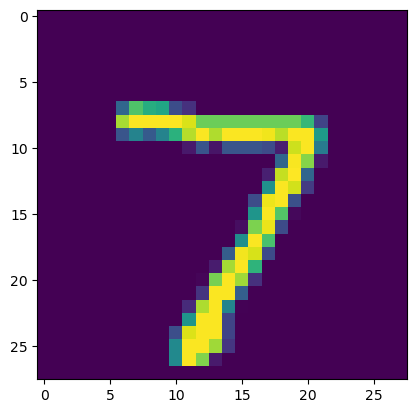

In [97]:
imgs, lbls = next(iter(test_loader))
img = imgs[0]#.reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(model.apply(params, np.ravel(img)))
print('pred', pred)
print('get', gt_lbl)

plt_img = img.reshape((28,28))
plt.imshow(plt_img); plt.show()